In [73]:
from shapely.geometry.polygon import Polygon
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy

In [18]:
# map 对象
from argoverse.map_representation.map_api import ArgoverseMap
am = ArgoverseMap()  # map 操作对象

E:\argoverse-api-ccuse\argoverse\map_representation\map_api.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
E:\argoverse-api-ccuse\argoverse\map_representation\map_api.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


In [3]:
# data loader 对象
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
# 设置路径
root_dir = '../forecasting_sample/data/'
afl = ArgoverseForecastingLoader(root_dir)  # loader对象
print('Total number of sequences:',len(afl))  # 文件夹中的seq，即数据文件的数量


Total number of sequences: 5


In [50]:
# 根据角度计算旋转矩阵
from argoverse.utils.se2 import SE2

def rotation_mat(theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    r_mat = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])
    return r_mat

def rotation(theta, city_name, x0, y0):
    data = copy.deepcopy(DataFrame(am.city_halluc_bbox_table[city_name]))
    # 转换为以现在的x0，y0 为中心的坐标
    data.iloc[:,0] = data.iloc[:,0] - x0
    data.iloc[:,1] = data.iloc[:,1] - y0
    data.iloc[:,2] = data.iloc[:,2] - x0
    data.iloc[:,3] = data.iloc[:,3] - y0
    translation_vector = np.array([0, 0])
    rotation_matrix = rotation_mat(theta)
    dst_se2_src = SE2(rotation=rotation_matrix, translation=translation_vector)
    # 起点转换
    start_point = np.array(data.iloc[:,:2])
    rotated_data_1 = DataFrame(dst_se2_src.inverse_transform_point_cloud(start_point))
    # 终点转换
    end_point = np.array(data.iloc[:,-2:])
    rotated_data_2 = DataFrame(dst_se2_src.inverse_transform_point_cloud(end_point))
    # 合并
    results = np.array(pd.concat([rotated_data_1, rotated_data_2],axis=1))

    return results

In [51]:
am.city_halluc_bbox_table

{'PIT': array([[3157.05311276, 1664.64502937, 3169.32205386, 1676.08986295],
        [2550.29379146, 1226.70455396, 2555.01302486, 1231.25902421],
        [2549.48134283, 1218.77664394, 2556.60119041, 1229.07895812],
        ...,
        [1978.61559201,  924.7597167 , 1989.81210172,  936.32818642],
        [2040.95102526,  982.23952084, 2056.72990177,  997.33165492],
        [2112.37130421, 1047.26683279, 2143.87323299, 1076.07765697]]),
 'MIA': array([[ 250.17084022, 1767.85900712,  255.6611325 , 1783.30972556],
        [ 255.75382143, 1767.2186543 ,  266.47287071, 1776.04522048],
        [ 251.92546688, 1767.63276669,  266.07094055, 1780.82092355],
        ...,
        [ 334.32921743, 1772.57933045,  338.14000093, 1787.33416533],
        [ 329.61766493, 1791.81067027,  333.75859923, 1807.38868822],
        [ 334.35257687, 1779.96511506,  344.50547707, 1787.55101587]])}

In [576]:
theta = np.pi * -0.25
x0, y0 = 2870,1530
range_dis_front = 50
range_dis_back = 20
range_dis_side = 10

In [577]:
res_PIT = rotation(theta,'PIT', x0, y0)
res_MIA = rotation(theta,'MIA', x0, y0)
res = {'PIT': res_PIT, 'MIA': res_MIA}
print(res)
DataFrame(res['PIT']).to_csv(r'e:\数据集\03_Argoverse\tmp1.csv')

{'PIT': array([[  107.76878927,   298.18561591,   108.35152129,   314.95378679],
       [  -11.60416145,  -440.52869464,   -11.4876563 ,  -433.9711959 ],
       [   -6.57277045,  -446.70906152,    -8.82311416,  -434.38973279],
       ...,
       [ -202.33445097, -1058.2734681 ,  -202.59746641, -1042.17619677],
       [ -198.9010027 ,  -973.55130126,  -198.41540246,  -951.72220032],
       [ -194.38049238,  -877.06828445,  -192.47759406,  -834.42072784]]), 'MIA': array([[-2020.69068133, -1684.30724754, -2027.73376621, -1669.49971685],
       [-2016.29011963, -1680.81228148, -2014.951932  , -1666.99144424],
       [-2019.28999678, -1683.22651526, -2018.61307157, -1663.89871976],
       ...,
       [-1964.51949475, -1621.46051567, -1972.25810769, -1608.33264102],
       [-1981.44967627, -1611.1934756 , -1989.53691568, -1597.25007074],
       [-1969.72551551, -1616.22145968, -1967.91037283, -1603.67823319]])}


PermissionError: [Errno 13] Permission denied: 'e:\\数据集\\03_Argoverse\\tmp1.csv'

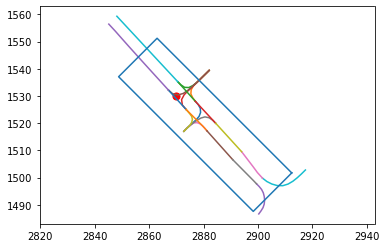

In [580]:
x1, y1 = range_dis_front, range_dis_side
x2, y2 = range_dis_front, -range_dis_side
x3, y3 = -range_dis_back, range_dis_side
x4, y4 = -range_dis_back, -range_dis_side
rotation_matrix = rotation_mat(theta)
dss = SE2(rotation=rotation_matrix, translation=np.array([0, 0]))
transformed_pts = np.array([[x1,y1],[x2,y2],[x4,y4],[x3,y3],[x1,y1]])
pts = dss.transform_point_cloud(transformed_pts)
tmpp = DataFrame(pts)
tmpp[0] = tmpp[0] + x0
tmpp[1] = tmpp[1] + y0

re_cl = am.find_local_lane_centerlines_Revised(0, 0,'PIT',res, range_dis_front,range_dis_back,range_dis_side)
# print(re_cl)
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.axis('equal')
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot(tmpp[0],tmpp[1])

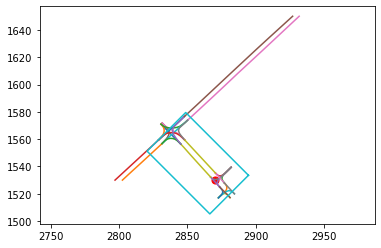

In [363]:
x1, y1 = range_dis_back, range_dis_side
x2, y2 = range_dis_back, -range_dis_side
x3, y3 = -range_dis_front, range_dis_side
x4, y4 = -range_dis_front, -range_dis_side
rotation_matrix = rotation_mat(theta)
dss = SE2(rotation=rotation_matrix, translation=np.array([0, 0]))
transformed_pts = np.array([[x1,y1],[x2,y2],[x4,y4],[x3,y3],[x1,y1]])
pts = dss.transform_point_cloud(transformed_pts)
tmpp = DataFrame(pts)
tmpp[0] = tmpp[0] + x0
tmpp[1] = tmpp[1] + y0

re_cl = am.find_local_lane_centerlines_Revised(0, 0,'PIT',res, range_dis_back,range_dis_front,range_dis_side)
# print(re_cl)
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.axis('equal')
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot(tmpp[0],tmpp[1])

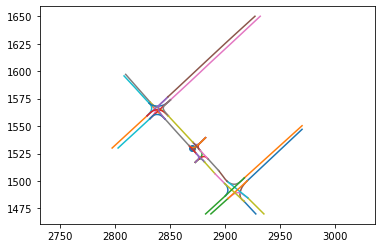

In [364]:
re_cl = am.find_local_lane_centerlines(x0, y0,'PIT', range_dis_front)
# print(re_cl)
plt.scatter(x0,y0, marker='o')
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.axis('equal')

## 测试shapely检查框覆盖路径可行性

In [14]:
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import MultiLineString

##### 覆盖框

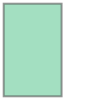

In [30]:
x0, y0 = 2870,1530
range_dis_front = 5
range_dis_back = 20
range_dis_side = 20
x1, y1 = x0+range_dis_front, y0+range_dis_side
x2, y2 = x0+range_dis_front, y0-range_dis_side
x3, y3 = x0-range_dis_back, y0+range_dis_side
x4, y4 = x0-range_dis_back, y0-range_dis_side
polygon = Polygon([[x1,y1],[x2,y2],[x4,y4],[x3,y3]])
display(polygon)

##### 路径


9604941
[2873.47123575 1526.87923865 2883.39872575 1540.7397631 ]
9604930
[2871.41839763 1515.67331246 2880.79508136 1529.26593208]


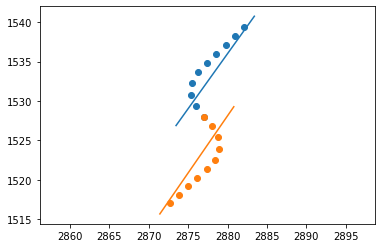

In [19]:
m = [87,76]
xm = []
for tt in m:
    print(am.city_halluc_tableidx_to_laneid_map['PIT'][str(tt)])
    z = am.city_halluc_tableidx_to_laneid_map['PIT'][str(tt)]
    print(am.city_halluc_bbox_table['PIT'][tt])
    y = am.city_halluc_bbox_table['PIT'][tt]
    x = am.city_lane_centerlines_dict['PIT'][z].centerline
    xm.append(x)
    xx = DataFrame(x)
    plt.scatter(xx[0],xx[1])
    plt.plot([y[0],y[2]],[y[1],y[3]])
    plt.axis('equal')

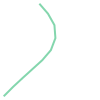

In [21]:
# 转换为shapely对象
line1 = LineString(x)
display(line1)

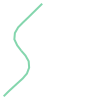

In [22]:
# 多个线对象
line2 = MultiLineString(xm)
display(line2)

##### 单条线检查是否相交

disjoint False
crosses True
contains False
intersects True


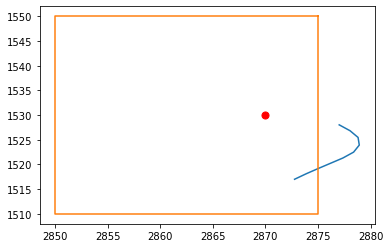

In [33]:
plt.plot(xx[0],xx[1])
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot([x1,x2,x4,x3,x1],[y1,y2,y4,y3,y1])
print('disjoint',polygon.disjoint(line1))
print('crosses',polygon.crosses(line1))
print('contains',polygon.contains(line1))
print('intersects',polygon.intersects(line1))

disjoint False
crosses False
contains True
intersects True


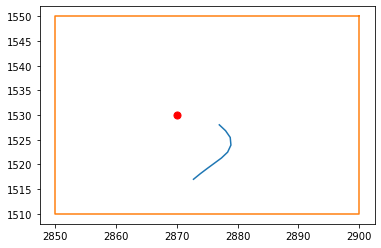

In [29]:
x0, y0 = 2870,1530
range_dis_front = 30
range_dis_back = 20
range_dis_side = 20
x1, y1 = x0+range_dis_front, y0+range_dis_side
x2, y2 = x0+range_dis_front, y0-range_dis_side
x3, y3 = x0-range_dis_back, y0+range_dis_side
x4, y4 = x0-range_dis_back, y0-range_dis_side
polygon = Polygon([[x1,y1],[x2,y2],[x4,y4],[x3,y3]])

plt.plot(xx[0],xx[1])
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot([x1,x2,x4,x3,x1],[y1,y2,y4,y3,y1])
print('disjoint',polygon.disjoint(line1))
print('crosses',polygon.crosses(line1))
print('contains',polygon.contains(line1))
print('intersects',polygon.intersects(line1))

disjoint True
crosses False
contains False
intersects False


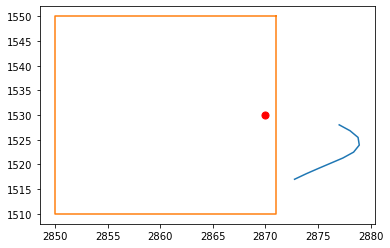

In [34]:
x0, y0 = 2870,1530
range_dis_front = 1
range_dis_back = 20
range_dis_side = 20
x1, y1 = x0+range_dis_front, y0+range_dis_side
x2, y2 = x0+range_dis_front, y0-range_dis_side
x3, y3 = x0-range_dis_back, y0+range_dis_side
x4, y4 = x0-range_dis_back, y0-range_dis_side
polygon = Polygon([[x1,y1],[x2,y2],[x4,y4],[x3,y3]])

plt.plot(xx[0],xx[1])
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot([x1,x2,x4,x3,x1],[y1,y2,y4,y3,y1])
print('disjoint',polygon.disjoint(line1))
print('crosses',polygon.crosses(line1))
print('contains',polygon.contains(line1))
print('intersects',polygon.intersects(line1))


##### 单条线检查是否相交

intersects False
===
intersects True
===


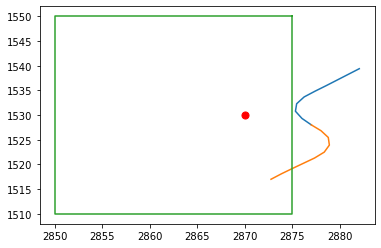

In [37]:
x0, y0 = 2870,1530
range_dis_front = 5
range_dis_back = 20
range_dis_side = 20
x1, y1 = x0+range_dis_front, y0+range_dis_side
x2, y2 = x0+range_dis_front, y0-range_dis_side
x3, y3 = x0-range_dis_back, y0+range_dis_side
x4, y4 = x0-range_dis_back, y0-range_dis_side
polygon = Polygon([[x1,y1],[x2,y2],[x4,y4],[x3,y3]])

for xx in xm:
    plt.plot(DataFrame(xx)[0],DataFrame(xx)[1])
    line0 = LineString(xx)
    # print('disjoint',polygon.disjoint(line0))
    # print('crosses',polygon.crosses(line0))
    # print('contains',polygon.contains(line0))
    print('intersects',polygon.intersects(line0))
    print('===')
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot([x1,x2,x4,x3,x1],[y1,y2,y4,y3,y1])

In [38]:
print('intersects',polygon.intersects(line2))

intersects True


In [39]:
for i in line2:
    print('intersects',polygon.intersects(i))

intersects False
intersects True


## 尝试使用shapely来检测

##### 旋转判定框

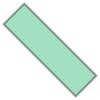

intersects True


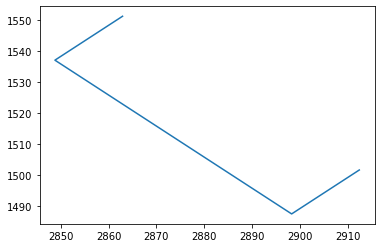

In [582]:
theta = np.pi * -0.25
x0, y0 = 2870,1530
range_dis_front = 50
range_dis_back = 20
range_dis_side = 10
x1, y1 = range_dis_front, range_dis_side
x2, y2 = range_dis_front, -range_dis_side
x3, y3 = -range_dis_back, range_dis_side
x4, y4 = -range_dis_back, -range_dis_side
rotation_matrix = rotation_mat(theta)
dss = SE2(rotation=rotation_matrix, translation=np.array([0, 0]))
transformed_pts = np.array([[x1,y1],[x2,y2],[x4,y4],[x3,y3]])
pts = dss.transform_point_cloud(transformed_pts)
tmpp = DataFrame(pts)
tmpp[0] = tmpp[0] + x0
tmpp[1] = tmpp[1] + y0
polygon1 = Polygon(pts)
display(polygon1)
plt.plot(DataFrame(pts)[0],DataFrame(pts)[1])
print('intersects',polygon1.intersects(line0))

##### 构造所有centerline的shapely对象

In [517]:
city = 'PIT'
line_set = {}
i = 1
centerline_ind = am.build_centerline_index()['PIT']  # 生成全部centerline
for ctlID, ctlinfo in centerline_ind.items():
    i += 1
    if i % 1000 == 0:
        print(i,'/',len(centerline_ind))
    line_set[ctlID] = LineString(ctlinfo.centerline)

1000 / 4952
2000 / 4952
3000 / 4952
4000 / 4952


In [585]:
est_id = []
i = 1
for id, info in line_set.items():
    # i += 1
    # if i >4: break
    # print(polygon.intersects(info))
    if polygon1.intersects(info):
        est_id.append(id)

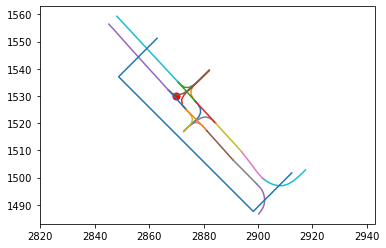

In [586]:
# 真值
true_id = [9604930, 9604941, 9608461, 9608467, 9608566, 9608572, 9608573, 9608574, 9608592, 9608862, 9609530, 9609547, 9609570, 9609593, 9609606, 9609643, 9609976, 9609992, 9609993, 9611654]
re_cl = [am.get_lane_segment_centerline(lane_id, city) for lane_id in true_id]
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.axis('equal')
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot(DataFrame(pts)[0],DataFrame(pts)[1])

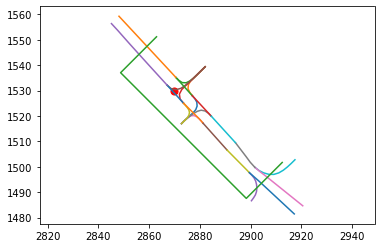

In [587]:
re_cl = [am.get_lane_segment_centerline(lane_id, city) for lane_id in est_id]
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.axis('equal')
plt.scatter(x0,y0, marker='o', s=50, c='r')
plt.plot(DataFrame(pts)[0],DataFrame(pts)[1])

## 变量保存

In [ ]:
import pickle

In [513]:
pickle.dump(line_set, open(r'e:\数据集\03_Argoverse\tmp2', 'wb'))

In [514]:
getback = pickle.load(open(r'e:\数据集\03_Argoverse\tmp2', 'rb'))

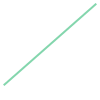

In [516]:
getback[9604854]

In [12]:
save_path =''
x = DataFrame([1,2,3])
print(x)
print(save_path+'s.csv')

   0
0  1
1  2
2  3
s.csv


In [13]:
x.to_csv(save_path+'s.csv')

### 测试封装包

In [10]:
from chenchencode.arg_customized import find_centerline_veh_coor

In [13]:
theta = np.pi * 0.75
city = 'PIT'
x0, y0 = 2870,1530
range_dis_front = 50
range_dis_back = 3
range_dis_side = 5

find = find_centerline_veh_coor(x0, y0, theta, city, range_dis_front,range_dis_back,range_dis_side)
re_cl = find.find()
print(re_cl[0])

E:\argoverse-api-ccuse\argoverse\map_representation\map_api.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  lane_polygons = np.array(self.get_vector_map_lane_polygons(city_name))
E:\argoverse-api-ccuse\argoverse\map_representation\map_api.py:79: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  driveable_areas = np.array(self.get_vector_map_driveable_areas(city_name))


[array([[2830.68273332, 1570.98943292,   12.7688036 ],
       [2832.29355785, 1569.36917107,   12.83505917],
       [2833.90438239, 1567.74890922,   12.82208252],
       [2835.51520693, 1566.12864738,   12.85322094],
       [2837.12603146, 1564.50838553,   12.87576389],
       [2838.736856  , 1562.88812369,   12.78684521],
       [2840.34768054, 1561.26786184,   12.75602531],
       [2841.95850507, 1559.64759999,   12.82040691],
       [2843.56932961, 1558.02733815,   12.84496212],
       [2845.18015415, 1556.4070763 ,   12.86096382]]), array([[2877.00721486, 1528.02497117,   13.21702385],
       [2876.02789169, 1529.32051275,   13.19907475],
       [2875.33853652, 1530.7791802 ,   13.1784544 ],
       [2875.46852482, 1532.29647258,   13.13689423],
       [2876.25427548, 1533.66936409,   13.1768198 ],
       [2877.39801738, 1534.82939637,   13.16438198],
       [2878.57887508, 1535.95403175,   13.18509388],
       [2879.74185337, 1537.09723768,   13.19215488],
       [2880.90356177, 15

KeyboardInterrupt: 

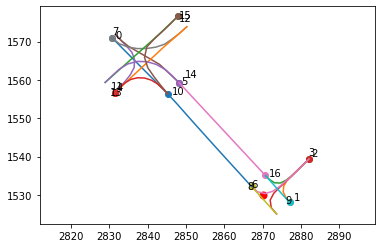

In [5]:
for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1])
    plt.scatter(re_cl_df[0][0],re_cl_df[1][0])
    plt.text(re_cl_df[0][0]+(np.random.random()-0.5)*3,re_cl_df[1][0]+(np.random.random()-0.5)*3, str(i))
    # plt.pause(0.5)
plt.axis('equal')
plt.scatter(x0,y0, marker='o', s=50, c='r')
# plt.plot(DataFrame(pts)[0],DataFrame(pts)[1])

### 实际数据测试

In [3]:
# from find_centerline_veh_coor import find_centerline_veh_coor
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

In [6]:
path = r'e:\argoverse-api-ccuse\forecasting_sample\data\12.csv'
data = pd.read_csv(path)
data = data.sort_values(by=['OBJECT_TYPE','TRACK_ID'])
data['TIMESTAMP'] -= data['TIMESTAMP'][0]
data['TIMESTAMP'] = data['TIMESTAMP'].round(1)
data.index = range(data.shape[0])
data.reset_index(drop=True)
data

,TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME
0,0.0,00000000-0000-0000-0000-000000001227,AGENT,565.883453,2276.380968,MIA
1,0.1,00000000-0000-0000-0000-000000001227,AGENT,565.876792,2275.899301,MIA
2,0.3,00000000-0000-0000-0000-000000001227,AGENT,565.759358,2275.167326,MIA
3,0.4,00000000-0000-0000-0000-000000001227,AGENT,565.760137,2274.681784,MIA
4,0.6,00000000-0000-0000-0000-000000001227,AGENT,565.791142,2273.640457,MIA
...,...,...,...,...,...,...
931,6.8,00000000-0000-0000-0000-000000002120,OTHERS,560.066466,2352.824079,MIA
932,7.0,00000000-0000-0000-0000-000000002120,OTHERS,560.285963,2351.625916,MIA
933,6.4,00000000-0000-0000-0000-000000002122,OTHERS,579.436583,2154.722253,MIA
934,6.5,00000000-0000-0000-0000-000000002122,OTHERS,579.436583,2154.722253,MIA


In [3]:
x0, y0, x1, y1 = data['X'][0], data['Y'][0], data['X'][1], data['Y'][1]
print(x0,y0,x1,y1,np.arctan2(y1-y0,x1-x0)/np.pi*180)
f = find_centerline_veh_coor(x0, y0, np.arctan2(x1,y1), 'MIA', 100, 100, 30)
re_cl = f.find()
DataFrame(re_cl[0])

565.883453069033 2276.3809675466728 565.8767924668086 2275.899301427396 -90.79225018984104


AssertionError: 

0    565.883453
1    565.876792
Name: X, dtype: float64 0    2276.380968
1    2275.899301
Name: Y, dtype: float64


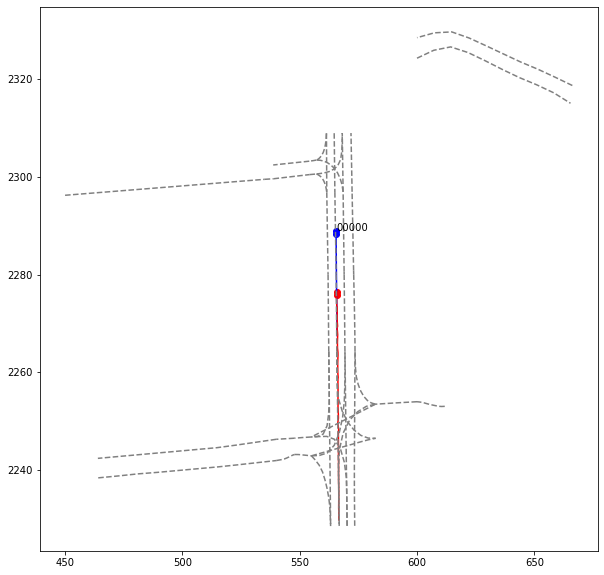

In [17]:
plt.figure(figsize=(10,10))
group = data.groupby('TRACK_ID')
for gname, gdata in group:
    c = 'r' if gdata['OBJECT_TYPE'].iloc[0] == 'AGENT' else 'b'
#     if i == 67: print(gname)
#     plt.plot(gdata['X'].rolling(5).mean(),gdata['Y'].rolling(5).mean(), c=c)
    plt.plot(gdata['X'],gdata['Y'], c=c)
    plt.scatter(gdata['X'].iloc[0:2],gdata['Y'].iloc[0:2], c=c)
    if gdata['OBJECT_TYPE'].iloc[0] == 'AGENT':
        print(gdata['X'].iloc[0:2],gdata['Y'].iloc[0:2])
        break
    plt.text(gdata['X'].iloc[0],gdata['Y'].iloc[0],gname[-5:])

for i in range(len(re_cl)):
    x = re_cl[i]
    # display(Polygon(x))
    re_cl_df = DataFrame(x)
    plt.plot(re_cl_df[0],re_cl_df[1],linestyle='--',c='gray')
plt.show()
# [65，24，83，13,31,30,23]
# [58 60 67 54 56]

# 矢量化表征

(2824.656144675323, 2888.787478325445, 1512.5566797446818, 1581.1017180545832)

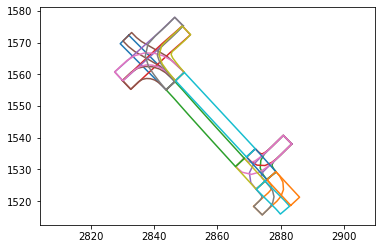

In [103]:
re_pl = am.find_local_lane_polygons([2840,2890,1525,1560],'PIT')
for i in range(len(re_pl)):
    x = re_pl[i]
    # display(Polygon(x))
    re_pl_df = DataFrame(x)
    plt.plot(re_pl_df[0],re_pl_df[1])
plt.axis('equal')